$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 6: Neural Networks

Zach Goodenow
<br>
CS 440
<br>
11/15/17

## Overview

You will write and apply code that trains neural networks of various numbers of hidden layers and units in each hidden layer and returns results as specified below.  You will do this once for a regression problem and once for a classification problem. 

## Required Code

Download [nn2.tar](http://www.cs.colostate.edu/~anderson/cs440/notebooks/nn2.tar) that was used in lecture and extract its contents, which are

* `neuralnetworks.py`
* `scaledconjugategradient.py`
* `mlutils.py`

Write the following functions that train and evaluate neural network models.

* `results = trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations, classify)`

The arguments to `trainNNs` are

* `X` is a matrix of input data of shape `nSamples x nFeatures`
* `T` is a matrix of target data of shape `nSamples x nOutputs`
* `trainFraction` is fraction of samples to use as training data. 1-`trainFraction` is number of samples for testing data
* `hiddenLayerStructures` is list of network architectures. For example, to test two networks, one with one hidden layer of 20 units, and one with 3 hidden layers with 5, 10, and 20 units in each layer, this argument would be `[[20], [5, 10, 20]]`.
* `numberRepetitions` is number of times to train a neural network.  Calculate training and testing average performance (two separate averages) of this many training runs.
* `numberIterations` is the number of iterations to run the scaled conjugate gradient algorithm when a neural network is trained.
* `classify` is set to `True` if you are doing a classification problem, in which case `T` must be a single column of target class integers.

This function returns `results` which is list with one element for each network structure tested.  Each element is a list containing 

* the hidden layer structure (as a list),
* a list of training data performance for each repetition, 
* a list of testing data performance for each repetition, and
* the number of seconds it took to run this many repetitions for this network structure.

This function should follow these steps:

  * For each network structure given in `hiddenLayerStructures`
    * For numberRepetitions
      * Use `ml.partition` to randomly partition X and T into training and testing sets.
      * Create a neural network of the given structure
      * Train it for numberIterations
      * Use the trained network to produce outputs for the training and for the testing sets
      * If classifying, calculate the fraction of samples incorrectly classified for training and testing sets.
       Otherwise, calculate the RMSE of training and testing sets.
      * Add the training and testing performance to a collection (such as a list) for this network structure
    * Add to a collection of all results the hidden layer structure, lists of training performance and testing performance, and seconds taken to do these repetitions.
  * return the collection of all results

Also write the following two functions. `summarize(results)` returns a list of lists like `results` but with the list of training performances replaced by their mean and the list of testing performances replaced by their mean.   
`bestNetwork(summary)` takes the output of `summarize(results)` and returns the best element of `results`, determined by the element that has the smallest test performance.

* `summary = summarize(results)` where `results` is returned by `trainNNs` and `summary` is like `results` with the training and testing performance lists replaced by their means
* `best = bestNetwork(summary)` where `summary` is returned by `summarize` and `best` is the best element of `summary`

In [2]:
# Replace this cell with several cells defining the above functions.
# from A6mysolution import *

import numpy as np
import mlutils as ml
import neuralnetworks as nn
import time
import scaledconjugategradient as scg



# returns a list of lists like results
# but with the list of training performances replaced by their mean
# and the list of testing performances replaced by their mean
def summarize(results):
    sumz = []
    for layer in results: #range(len(results)/3):
        sumz.append([layer[0], np.mean(layer[1]), np.mean(layer[2]), layer[3]])
    return sumz


# takes the output of summarize(results) and returns the best element of results,
# determined by the element that has the smallest test performance.
def bestNetwork(summary):
    bestNet = [-1]
    smallestTestP = float('inf')
    for layer in summary:
        if layer[2] < smallestTestP:
            smallestTestP = layer[2]
            bestNet = layer
    return bestNet


# Helper when not a classify problem
def performance(X, T, trainFraction, hidden, numberRepetitions, numberIterations):
    # Make the lists for train and test data performance
    trainP = []
    testP = []

    # For numberRepetitions
    for rep in range(numberRepetitions):
        # Use ml.partition to randomly partition X and T into training and testing sets.
        Xtrain, Ttrain, Xtest, Ttest = ml.partition(X, T, (trainFraction, 1 - trainFraction), classification=False)

        # Create a neural network of the given structure
        nnet = nn.NeuralNetwork(X.shape[1], hidden, T.shape[1])

        # Train it for numberIterations
        # nnet.train(X, T, numberIterations)
        nnet.train(Xtrain, Ttrain, numberIterations)

        # Use the trained network to produce outputs for the training and for the testing sets
        Ytrain = nnet.use(Xtrain)
        Ytest = nnet.use(Xtest)

        # Calculate the RMSE of training and testing sets.
        trainRMSE = np.sqrt(np.mean((Ytrain - Ttrain) ** 2))
        testRMSE = np.sqrt(np.mean((Ytest - Ttest) ** 2))

        # Add the training and testing performance to a collection (such as a list) for this network structure
        trainP.append(trainRMSE)
        testP.append(testRMSE)

    # Return trainP and testP
    return trainP, testP


# Helper when classify problem
def performanceC(X, T, trainFraction, hidden, numberRepetitions, numberIterations):
    # Make the lists for train and test data performance
    trainP = []
    testP = []

    # For numberRepetitions
    for rep in range(numberRepetitions):
        # Use ml.partition to randomly partition X and T into training and testing sets.
        Xtrain, Ttrain, Xtest, Ttest = ml.partition(X, T, (trainFraction, 1 - trainFraction), classification=True)

        # Create a neural network of the given structure
        nnet = nn.NeuralNetworkClassifier(X.shape[1], hidden, len(np.unique(T)))

        # Train it for numberIterations
        # nnet.train(X, T, numberIterations)
        nnet.train(Xtrain, Ttrain, numberIterations)

        # Use the trained network to produce outputs for the training and for the testing sets
        Ytrain = nnet.use(Xtrain)
        Ytest = nnet.use(Xtest)

        # Calculate the fraction of samples incorrectly classified for training and testing sets
        trainFrac = np.sum(Ytrain != Ttrain) / Ttrain.shape[0]
        testFrac = np.sum(Ytest != Ttest) / Ttest.shape[0]

        # Add the training and testing performance to a collection (such as a list) for this network structure
        trainP.append(trainFrac)
        testP.append(testFrac)

    # Return trainP and testP
    return trainP, testP


# This function returns results which is a list with one element for each network structure tested
def trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations, classify):
    results = []
    # For each network structure given in hiddenLayerStructures
    for hidden in hiddenLayerStructures:
        # Make the element for this structure
        element = [hidden]

        # Clock the time
        startTime = time.time()

        # Get preformance
        args = [X, T, trainFraction, hidden, numberRepetitions, numberIterations]
        trainP, testP = performanceC(*args) if classify else performance(*args)

        # Add to a collection of all results the hidden layer structure,
        # lists of training performance and testing performance,
        element.append(trainP)
        element.append(testP)
        # and seconds taken to do these repetitions.
        element.append(time.time() - startTime)

        # add the element for this hidden layer structure to results
        results.append(element)
    # return the collection of all results
    return results


## Examples


In [2]:
X = np.arange(10).reshape((-1,1))
T = X + 1 + np.random.uniform(-1, 1, ((10,1)))

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

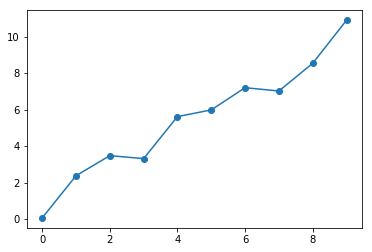

In [4]:
plt.plot(X, T, 'o-');

In [5]:
nnet = nn.NeuralNetwork(X.shape[1], 2, T.shape[1])
nnet.train(X, T, 100)
nnet.getErrorTrace()

array([ 0.70710678,  0.2107949 ,  0.20702665,  0.20132449,  0.18518392,
        0.17232964,  0.16822303,  0.16615813,  0.16563333,  0.16525081,
        0.16141957,  0.16071474,  0.15955935,  0.15857846,  0.15591168,
        0.15568618,  0.15469079,  0.15469079,  0.15469079,  0.15469079,
        0.15469079,  0.15469079,  0.15469079,  0.15469079,  0.15469079,
        0.15469079,  0.15469079,  0.15469079,  0.15469079,  0.15469079,
        0.15469079,  0.15114298,  0.15043166,  0.13955391,  0.13270768,
        0.13055815,  0.12348023,  0.12239773,  0.12209473,  0.12176139,
        0.12124539,  0.11790664,  0.11511939,  0.11455931,  0.11378924,
        0.11370848,  0.11338512,  0.11253055,  0.11206817,  0.11190374,
        0.11184639,  0.11181289,  0.11175395,  0.11041573,  0.11038681,
        0.11036222,  0.10994846,  0.10979124,  0.10959206,  0.10952766,
        0.10933765,  0.10896495,  0.10879027,  0.10871735,  0.10869011,
        0.10867464,  0.10866237,  0.10743954,  0.10700727,  0.10

In [6]:
nnet = nn.NeuralNetwork(X.shape[1], [5, 5, 5], T.shape[1])
nnet.train(X, T, 100)
nnet.getErrorTrace()

array([ 0.70710678,  0.67934314,  0.67934314,  0.66455474,  0.66455474,
        0.55439484,  0.42086714,  0.42086714,  0.38826725,  0.23914782,
        0.22133782,  0.20846806,  0.20765594,  0.20187677,  0.18717497,
        0.1856866 ,  0.16752138,  0.16670259,  0.16663715,  0.16187822,
        0.16046265,  0.15987411,  0.15939188,  0.15900142,  0.15893206,
        0.15870221,  0.15766248,  0.15765133,  0.15602709,  0.15517567,
        0.15516149,  0.15489062,  0.15489062,  0.15489062,  0.15489062,
        0.15489062,  0.15489062,  0.15489062,  0.15482987,  0.15392795,
        0.15348424,  0.15215688,  0.15209667,  0.1520738 ,  0.15207099,
        0.15172521,  0.1515881 ,  0.15148947,  0.15146502,  0.1514168 ,
        0.1513499 ,  0.151325  ,  0.15129201,  0.15113232,  0.15108189,
        0.15106422,  0.15104467,  0.1510064 ,  0.15098951,  0.15096556,
        0.15087405,  0.15083336,  0.15057686,  0.15047286,  0.14902344,
        0.14518735,  0.1444028 ,  0.14371341,  0.14259808,  0.14

In [7]:
results = trainNNs(X, T, 0.8, [2, 10, [10, 10]], 5, 100, classify=False)
results

[[2,
  [0.44720193909454525,
   0.51066055588104742,
   0.46763474408362565,
   0.50393255506286905,
   0.50151351125324395],
  [0.45589721264201583,
   0.43939394466276721,
   0.36000861747369078,
   0.31458730904380228,
   0.035933843353031208],
  0.22325611114501953],
 [10,
  [0.29816469008258245,
   0.41185293686435703,
   0.31930274338262549,
   0.47049715876791293,
   0.52140557187154213],
  [0.68050710713741047,
   0.30757054700188907,
   0.73615160062363583,
   0.27472000175538219,
   0.13824001073944114],
  0.18542218208312988],
 [[10, 10],
  [0.4240906507015787,
   0.43724950734937074,
   0.41189188742507615,
   0.27041391738873133,
   0.50241230831322126],
  [0.19926093523453925,
   0.26712241053467856,
   0.19951097974210749,
   0.67229422162115482,
   0.30468761077841261],
  0.23030495643615723]]

In [8]:
results = trainNNs(X, T, 0.8, [0, 1, 2, 10, [10, 10], [5, 5, 5, 5], [2]*5], 50, 400, classify=False)

In [9]:
summarize(results)

[[0, 0.62393195959020031, 0.64580246473906899, 0.04751896858215332],
 [1, 0.62959634508358631, 0.62452648593264437, 5.387493133544922],
 [2, 0.43655171853632785, 0.38142794952012438, 7.28003191947937],
 [10, 0.16000481568252789, 0.14067339999099346, 7.718148946762085],
 [[10, 10], 0.10575320298818675, 0.093838513591294331, 9.809055089950562],
 [[5, 5, 5, 5], 0.34143869333852706, 0.29121303875507004, 14.299608945846558],
 [[2, 2, 2, 2, 2],
  0.51150242561293158,
  0.54393886439056871,
  15.726140022277832]]

In [10]:
best = bestNetwork(summarize(results))
print(best)
print('Hidden Layers {} Average RMSE Training {:.2f} Testing {:.2f} Took {:.2f} seconds'.format(*best))

[[10, 10], 0.10575320298818675, 0.093838513591294331, 9.809055089950562]
Hidden Layers [10, 10] Average RMSE Training 0.11 Testing 0.09 Took 9.81 seconds


Hummm...neural nets with no hidden layers did best on this simple data set.  Why?  Remember what "best" means.

## Data for Regression Experiment

From the UCI Machine Learning Repository, download the [Appliances energy prediction](http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction) data.  You can do this by visiting the Data Folder for this data set, or just do this:

     !wget http://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv



Read this data into python.  One suggestion is to use the `loadtxt` function in the `numpy` package.  You may ignore the first column of each row which contains a data and time.  Also ignore the last two columns of random variables.  We will not use that in our modeling of this data.  You will also have to deal with the double quotes that surround every value in every field.  Read the first line of this file to get the names of the features.

Once you have read this in correctly, you should see values like this:

#### Load in data

I had this working fine for my code in pycharm but it isnt working the same way in jupyter notebook now.  This is the code that worked for me in pycharm

In [ ]:
# data = np.loadtxt("energydata_complete.csv", delimiter=',',
#                   dtype='str', usecols=1 + np.arange(26))
# data = np.chararray.replace(data, '"', '')
# data = np.chararray.replace(data, ' ', '')
# names, data = data[0], data[1:]
# data = np.array(data).astype(float)

# Xenergy, Tenergy = data[:, 2:], data[:, :2]
# Xnames, Tnames = names[2:], names[:2]

But I changed it to the following to get it working.

In [40]:
# Get names
f = open("energydata_complete.csv", "r")
header = f.readline()
names = header.replace('"', '').split(',')
names = names[1:-2]
names

['Appliances',
 'lights',
 'T1',
 'RH_1',
 'T2',
 'RH_2',
 'T3',
 'RH_3',
 'T4',
 'RH_4',
 'T5',
 'RH_5',
 'T6',
 'RH_6',
 'T7',
 'RH_7',
 'T8',
 'RH_8',
 'T9',
 'RH_9',
 'T_out',
 'Press_mm_hg',
 'RH_out',
 'Windspeed',
 'Visibility',
 'Tdewpoint']

In [41]:
# get data
data = np.genfromtxt("energydata_complete.csv", dtype=str, comments=None, delimiter=",", skip_header=1, usecols=1+np.arange(26))
data = np.chararray.strip(data, "\"")
data = np.chararray.strip(data, " ")
data = np.array(data).astype(float)

In [42]:
data[0]

array([  60.        ,   30.        ,   19.89      ,   47.59666667,
         19.2       ,   44.79      ,   19.79      ,   44.73      ,
         19.        ,   45.56666667,   17.16666667,   55.2       ,
          7.02666667,   84.25666667,   17.2       ,   41.62666667,
         18.2       ,   48.9       ,   17.03333333,   45.53      ,
          6.6       ,  733.5       ,   92.        ,    7.        ,
         63.        ,    5.3       ])

In [43]:
Xenergy, Tenergy = data[:, 2:], data[:, :2]
Xnames, Tnames = names[2:], names[:2]

In [45]:
Xnames, Tnames

(['T1',
  'RH_1',
  'T2',
  'RH_2',
  'T3',
  'RH_3',
  'T4',
  'RH_4',
  'T5',
  'RH_5',
  'T6',
  'RH_6',
  'T7',
  'RH_7',
  'T8',
  'RH_8',
  'T9',
  'RH_9',
  'T_out',
  'Press_mm_hg',
  'RH_out',
  'Windspeed',
  'Visibility',
  'Tdewpoint'],
 ['Appliances', 'lights'])

In [48]:
data.shape

(19735, 26)

In [49]:
data[:2,:]

array([[  60.        ,   30.        ,   19.89      ,   47.59666667,
          19.2       ,   44.79      ,   19.79      ,   44.73      ,
          19.        ,   45.56666667,   17.16666667,   55.2       ,
           7.02666667,   84.25666667,   17.2       ,   41.62666667,
          18.2       ,   48.9       ,   17.03333333,   45.53      ,
           6.6       ,  733.5       ,   92.        ,    7.        ,
          63.        ,    5.3       ],
       [  60.        ,   30.        ,   19.89      ,   46.69333333,
          19.2       ,   44.7225    ,   19.79      ,   44.79      ,
          19.        ,   45.9925    ,   17.16666667,   55.2       ,
           6.83333333,   84.06333333,   17.2       ,   41.56      ,
          18.2       ,   48.86333333,   17.06666667,   45.56      ,
           6.48333333,  733.6       ,   92.        ,    6.66666667,
          59.16666667,    5.2       ]])

Use the first two columns, labelled `Appliances` and `lights` as the target variables, and the remaining 24 columns as the input features.  So

In [50]:
Xenergy.shape, Tenergy.shape

((19735, 24), (19735, 2))

Train several neural networks on all of this data for 100 iterations.  Plot the error trace (nnet.getErrorTrace()) to help you decide now many iterations might be needed.  100 may not be enough.  If for your larger networks the error is still decreasing after 100 iterations you should train all nets for more than 100 iterations.

Now use your `trainNNs`, `summarize`, and `bestNetwork` functions on this data to investigate various network sizes.

In [58]:
results = trainNNs(Xenergy, Tenergy, 0.8, [0, 5, [5, 5], [10, 10]], 10, 100, classify=False)

In [59]:
summarize(results)

[[0, 67.246327467224845, 66.845098754546285, 2.1941068172454834],
 [5, 65.412421709326722, 65.76296629083761, 18.187517881393433],
 [[5, 5], 64.756433763273691, 64.825061510644289, 25.871137857437134],
 [[10, 10], 62.973929637377125, 63.873748425809893, 48.28145098686218]]

[[0, 67.046960179422285, 67.644136371408763, 0.998682975769043],
 [5, 65.301632625880842, 66.328853488839485, 13.130361795425415],
 [[5, 5], 64.277382425810785, 66.416365860755761, 19.365249395370483],
 [[10, 10], 62.741905999268582, 64.979550044221469, 33.62221097946167]]

In [60]:
bestNetwork(summarize(results))

[[10, 10], 62.973929637377125, 63.873748425809893, 48.28145098686218]

[[10, 10], 62.741905999268582, 64.979550044221469, 33.62221097946167]

Test at least 10 different hidden layer structures.  Larger numbers of layers and units may do the best on training data, but not on testing data. Why?

I looked at

https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

and 

https://www.edge.org/response-detail/10351

to get more information about hidden layer selection.  Here are a few things I took away from them:

**the optimal size of the hidden layer is usually between the size of the input and size of the output layers**

In sum, for most problems, one could probably get decent performance (even without a second optimization step) by setting the hidden layer configuration using just two rules: (i) number of hidden layers equals one; and (ii) the number of neurons in that layer is the mean of the neurons in the input and output layers.

In [51]:
hidLay = np.arange(1, 24, 2)

[ 1  3  5  7  9 11 13 15 17 19 21 23]


In [54]:
results = trainNNs(Xenergy, Tenergy, 0.8, [1,2,3,[1,1],[3,3]], 10, 100, classify=False)

In [55]:
summarize(results)

[[1, 70.542028327535618, 69.813916938004255, 10.42564606666565],
 [2, 66.56619747359737, 65.600292802769943, 15.438579082489014],
 [3, 65.927445045533617, 65.65752728566369, 16.82727885246277],
 [[1, 1], 70.499452140861464, 69.979705945829892, 14.435991048812866],
 [[3, 3], 65.548526554845154, 67.07739844887422, 25.328215837478638]]

[[1, 70.542028327535618, 69.813916938004255, 10.42564606666565],
 [2, 66.56619747359737, 65.600292802769943, 15.438579082489014],
 [3, 65.927445045533617, 65.65752728566369, 16.82727885246277],
 [[1, 1], 70.499452140861464, 69.979705945829892, 14.435991048812866],
 [[3, 3], 65.548526554845154, 67.07739844887422, 25.328215837478638]]

In [56]:
bestNetwork(summarize(results))

[2, 66.56619747359737, 65.600292802769943, 15.438579082489014]

[2, 66.56619747359737, 65.600292802769943, 15.438579082489014]

Of the 5 hidden layers [1,2,3,[1,1],[3,3]], it looks like 2 is preforming the best but still not as good as [10, 10].  Lets try 5 more

In [61]:
results = trainNNs(Xenergy, Tenergy, 0.8, [10, 20, [10,10,10]], 10, 100, classify=False)

In [62]:
summarize(results)

[[10, 64.118591038227308, 65.5351334387978, 31.006136894226074],
 [20, 63.346383330572664, 64.21213169171952, 45.92880320549011],
 [[10, 10, 10], 62.915830745684886, 64.811774747259051, 62.98681426048279]]

In [63]:
bestNetwork(summarize(results))

[20, 63.346383330572664, 64.21213169171952, 45.92880320549011]

Since there are 24 inputs, try 1 layer with 24 units along with a few others based off the data

In [66]:
results = trainNNs(Xenergy, Tenergy, 0.8, [24, [9,9,6], [9,9,1,1,1,1,1,1]], 10, 100, classify=False)
summarize(results)

[[24, 62.479298591069856, 65.174802918180291, 55.514917850494385],
 [[9, 9, 6], 63.577118048562753, 65.242441398254016, 49.32772874832153],
 [[9, 9, 1, 1, 1, 1, 1, 1],
  70.434051812211479,
  70.130115308929504,
  51.72939205169678]]

In [67]:
bestNetwork(summarize(results))

[24, 62.479298591069856, 65.174802918180291, 55.514917850494385]

Try 200 itterations

In [68]:
results = trainNNs(Xenergy, Tenergy, 0.8, [24], 10, 200, classify=False)
summarize(results)
print()
bestNetwork(summarize(results))

[24, 61.032363660984018, 62.45302977869094, 115.47919297218323]

Notice that 24 trained at 100 iterations preformed worse than 24 trained at 200 iterations and is now the best preforming.  Lets use this net.

Now train another network with your best hidden layer structure on 0.8 of the data and use the trained network on the testing data (the remaining 0.2 of the date).  As before use `ml.partition` to produce the training and testing sets.

In [ ]:
# Use ml.partition to randomly partition X and T into training and testing sets.
Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xenergy, Tenergy, (0.8, 0.2), classification=False)

In [118]:
# Create a neural network of the given structure
nnet = nn.NeuralNetwork(Xenergy.shape[1], [24, 24], Tenergy.shape[1])
# train another network with your best hidden layer structure on 0.8 of the data
nnet.train(Xtrain, Ttrain, 300)
# use the trained network on the testing data
Ytest = nnet.use(Xtest)

# Calculate the RMSE of training and testing sets.
testRMSE = np.sqrt(np.mean((Ytest - Ttest) ** 2))

Train some networks by calling the NeuralNetwork constructor and train method and plot the error trace to help you decide now many iterations might be needed.

In [119]:
testRMSE

56.226449756625087

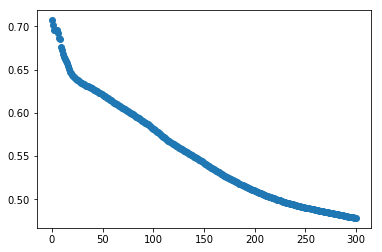

In [120]:
plt.plot(nnet.getErrorTrace(), 'o');

This plot shows the nnet should be trained for more iterations.

In [121]:
# Create a neural network of the given structure
nnet = nn.NeuralNetwork(Xenergy.shape[1], [24, 24], Tenergy.shape[1])
# train another network with your best hidden layer structure on 0.8 of the data
nnet.train(Xtrain, Ttrain, 600)
# use the trained network on the testing data
Ytest = nnet.use(Xtest)

# Calculate the RMSE of training and testing sets.
testRMSE = np.sqrt(np.mean((Ytest - Ttest) ** 2))

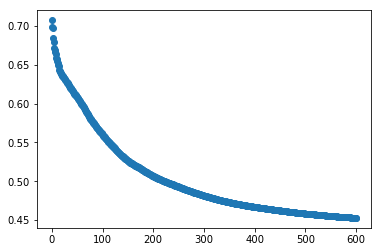

In [122]:
plt.plot(nnet.getErrorTrace(), 'o');

In [123]:
# Create a neural network of the given structure
nnet = nn.NeuralNetwork(Xenergy.shape[1], [24, 24, 24], Tenergy.shape[1])
# train another network with your best hidden layer structure on 0.8 of the data
nnet.train(Xtrain, Ttrain, 600)
# use the trained network on the testing data
Ytest = nnet.use(Xtest)

# Calculate the RMSE of training and testing sets.
testRMSE = np.sqrt(np.mean((Ytest - Ttest) ** 2))

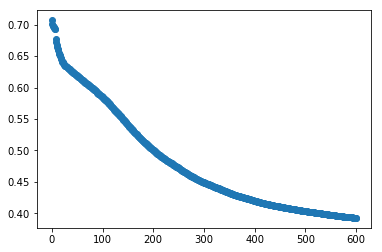

In [124]:
plt.plot(nnet.getErrorTrace(), 'o');

**SORRY FOR THE UNORGANIZED NOTEBOOK**
A little crunched on time, but the error trace is looking better with [24,24,24] trained for 600 times.

In [125]:
# Create a neural network of the given structure
nnet = nn.NeuralNetwork(Xenergy.shape[1], [24, 24, 24], Tenergy.shape[1])
# train another network with your best hidden layer structure on 0.8 of the data
nnet.train(Xtrain, Ttrain, 1000)
# use the trained network on the testing data
Ytest = nnet.use(Xtest)

# Calculate the RMSE of training and testing sets.
testRMSE = np.sqrt(np.mean((Ytest - Ttest) ** 2))

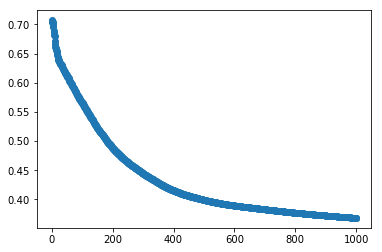

In [126]:
plt.plot(nnet.getErrorTrace(), 'o');

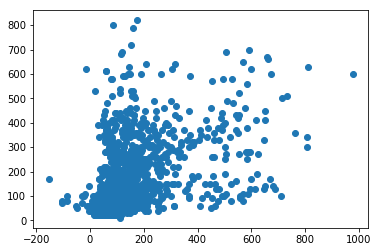

In [127]:
T_App = Ttest[:,0]
Y_App = Ytest[:,0]
plt.plot(Y_App, T_App, 'o'); # Appliances plot

This plot is looking a little better (more linear) but still not good.  

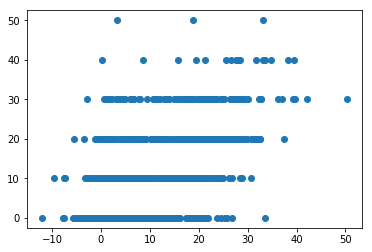

In [128]:
T_lights = Ttest[:,1]
Y_lights = Ytest[:,1]
plt.plot(Y_lights, T_lights, 'o'); # lights plot

This plot is looking a little better (more linear) but still not good.  

24 trainRMSE: 59.55
24 testRMSE: 61.12
vs.
[10, 10] trainRMSE: 59.75
[10, 10] testRMSE: 64.04

Still use 24.

For the testing data, plot the predicted and actual `Appliances` energy use, and the predicted and actual `lights` energy use, in two separate plots.  Discuss what you see.

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
Ttest.shape, Ytest.shape

((3947, 2), (3947, 2))

In [88]:
T_App = Ttest[:,0]
Y_App = Ytest[:,0]

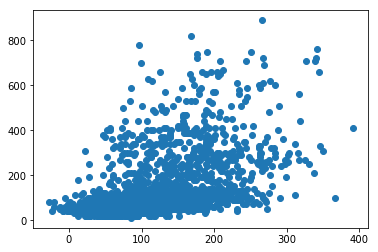

In [95]:
plt.plot(Y_App, T_App, 'o'); # Appliances plot

This plot does not look good because it does not have a linear trend.  If it were perfect, it would look like the line y = x because the predicted would be the same as the actual.

In [96]:
T_lights = Ttest[:,1]
Y_lights = Ytest[:,1]

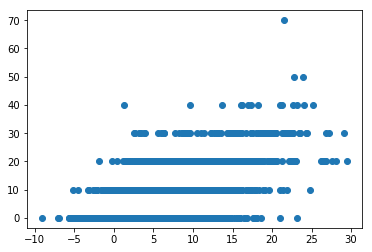

In [97]:
plt.plot(Y_lights, T_lights, 'o'); # lights plot

This plot looks a little better but still not great.  It the layers might point towards the lights being a classification problem.

What if the nnet was trained longer?

In [104]:
# Use ml.partition to randomly partition X and T into training and testing sets.
Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xenergy, Tenergy, (0.8, 0.2), classification=False)

# Create a neural network of the given structure
nnet = nn.NeuralNetwork(Xenergy.shape[1], 24, Tenergy.shape[1])

# Train it
nnet.train(Xtrain, Ttrain, 1000)

# Use the trained network to produce outputs for the training and for the testing sets
Ytrain = nnet.use(Xtrain)
Ytest = nnet.use(Xtest)

# Calculate the RMSE of training and testing sets.
trainRMSE = np.sqrt(np.mean((Ytrain - Ttrain) ** 2))
testRMSE = np.sqrt(np.mean((Ytest - Ttest) ** 2))

In [105]:
trainRMSE, testRMSE

(58.142177396299331, 57.98890538661788)

In [106]:
T_App = Ttest[:,0]
Y_App = Ytest[:,0]

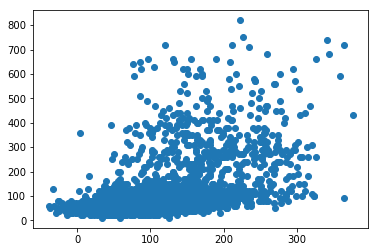

In [107]:
plt.plot(Y_App, T_App, 'o');

In [108]:
T_lights = Ttest[:,1]
Y_lights = Ytest[:,1]

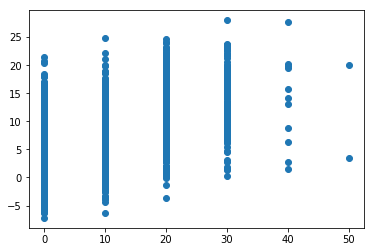

In [109]:
plt.plot(T_lights, Y_lights, 'o');

## Data for Classification Experiment

From the UCI Machine Learning Repository, download the [Anuran Calls (MFCCs)](http://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29) data.  You can do this by visiting the Data Folder for this data set, or just do this:

     !wget 'http://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran Calls (MFCCs).zip'
     !unzip Anuran*zip
     
Read the data in the file `Frogs_MFCCs.csv` into python.  This will be a little tricky. Each line of the file is a sample of audio features plus three columns that label the sample by family, genus, and species. We will try to predict the species.  The tricky part is that the species is given as text.  We need to convert this to a target class, as an integer. The `numpy` function `unique` will come in handy here.

In [152]:
# Get names
f = open("Frogs_MFCCs.csv", "r")
header = f.readline()
names = header.replace('"', '').split(',')
names = names[1:-1]
names

['MFCCs_ 2',
 'MFCCs_ 3',
 'MFCCs_ 4',
 'MFCCs_ 5',
 'MFCCs_ 6',
 'MFCCs_ 7',
 'MFCCs_ 8',
 'MFCCs_ 9',
 'MFCCs_10',
 'MFCCs_11',
 'MFCCs_12',
 'MFCCs_13',
 'MFCCs_14',
 'MFCCs_15',
 'MFCCs_16',
 'MFCCs_17',
 'MFCCs_18',
 'MFCCs_19',
 'MFCCs_20',
 'MFCCs_21',
 'MFCCs_22',
 'Family',
 'Genus',
 'Species']

In [153]:
names = np.delete(names, [21,22])
names = np.array(names).astype(str)
names

array(['MFCCs_ 2', 'MFCCs_ 3', 'MFCCs_ 4', 'MFCCs_ 5', 'MFCCs_ 6',
       'MFCCs_ 7', 'MFCCs_ 8', 'MFCCs_ 9', 'MFCCs_10', 'MFCCs_11',
       'MFCCs_12', 'MFCCs_13', 'MFCCs_14', 'MFCCs_15', 'MFCCs_16',
       'MFCCs_17', 'MFCCs_18', 'MFCCs_19', 'MFCCs_20', 'MFCCs_21',
       'MFCCs_22', 'Species'], 
      dtype='<U8')

In [221]:
# get data
data = np.genfromtxt("Frogs_MFCCs.csv", dtype=str, comments=None, delimiter=",", skip_header=1, usecols=1+np.arange(24))
data.shape

(7195, 24)

In [222]:
data = np.delete(data, [21,22], axis=1)
data.shape

(7195, 22)

In [223]:
data[0]

array(['0.152936298220384', '-0.105585902844019', '0.200721914808566',
       '0.317201062343259', '0.260763853131077', '0.100944640810053',
       '-0.150062604917616', '-0.17112763198601', '0.124676436148438',
       '0.188654145822323', '-0.0756217229244772', '-0.156435925226375',
       '0.0822451152835443', '0.135752042383891', '-0.0240166450287792',
       '-0.108351107221198', '-0.0776225214037558', '-0.00956780151914234',
       '0.0576839754007957', '0.118680135068692', '0.0140384456733697',
       'AdenomeraAndre'], 
      dtype='<U22')

In [224]:
Xanuran, Tanuran = data[:, :-1], data[:,-1]
b, c = np.unique(Tanuran, return_inverse=True)
Tanuran = c
Tanuran = Tanuran[np.newaxis].T

In [225]:
# Xanuran = Xanuran.astype(np.float32)
Xanuran = np.array(Xanuran).astype(np.float64)

In [226]:
np.unique(Tanuran, )

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [227]:
Xanuran.shape, Tanuran.shape # ((7195, 21), (7195, 1))

((7195, 21), (7195, 1))

In [228]:
Xanuran[:2,:]

array([[ 0.15, -0.11,  0.2 ,  0.32,  0.26,  0.1 , -0.15, -0.17,  0.12,
         0.19, -0.08, -0.16,  0.08,  0.14, -0.02, -0.11, -0.08, -0.01,
         0.06,  0.12,  0.01],
       [ 0.17, -0.1 ,  0.27,  0.34,  0.27,  0.06, -0.22, -0.21,  0.17,
         0.27, -0.1 , -0.25,  0.02,  0.16,  0.01, -0.09, -0.06, -0.04,
         0.02,  0.08,  0.03]])

In [22]:
Xanuran[:2,:]

array([[ 0.1529363 , -0.1055859 ,  0.20072191,  0.31720106,  0.26076385,
         0.10094464, -0.1500626 , -0.17112763,  0.12467644,  0.18865415,
        -0.07562172, -0.15643593,  0.08224512,  0.13575204, -0.02401665,
        -0.10835111, -0.07762252, -0.0095678 ,  0.05768398,  0.11868014,
         0.01403845],
       [ 0.17153426, -0.09897474,  0.26842522,  0.33867186,  0.2683531 ,
         0.06083509, -0.22247464, -0.20769267,  0.17088287,  0.27095828,
        -0.09500394, -0.25434147,  0.02278623,  0.1633201 ,  0.01202228,
        -0.09097401, -0.05650952, -0.03530336,  0.02013996,  0.08226299,
         0.02905574]])

In [230]:
Tanuran[:2]

array([[0],
       [0]])

In [23]:
Tanuran[:2]

array([[0],
       [0]])

In [231]:
for i in range(10):
    print('{} samples in class {}'.format(np.sum(Tanuran==i), i))

672 samples in class 0
3478 samples in class 1
542 samples in class 2
310 samples in class 3
472 samples in class 4
1121 samples in class 5
270 samples in class 6
114 samples in class 7
68 samples in class 8
148 samples in class 9


In [24]:
for i in range(10):
    print('{} samples in class {}'.format(np.sum(Tanuran==i), i))

672 samples in class 0
3478 samples in class 1
542 samples in class 2
310 samples in class 3
472 samples in class 4
1121 samples in class 5
270 samples in class 6
114 samples in class 7
68 samples in class 8
148 samples in class 9


In [191]:
results = trainNNs(Xanuran, Tanuran, 0.8, [0, 5, [5, 5]], 5, 100, classify=True)

In [192]:
summarize(results)

[[0, 0.031167477414871435, 0.035302293259207786, 2.573090076446533],
 [5, 0.033877692842251561, 0.043224461431549691, 5.259038925170898],
 [[5, 5], 0.076198749131341212, 0.086865879082696315, 6.18447732925415]]

In [25]:
results = trainNNs(Xanuran, Tanuran, 0.8, [0, 5, [5, 5]], 5, 100, classify=True)

In [26]:
summarize(results)

[[0, 0.028179291174426684, 0.034885337039610845, 2.706338405609131],
 [5, 0.035267546907574707, 0.041000694927032663, 5.346082448959351],
 [[5, 5], 0.046699096594857534, 0.057956914523974987, 6.503756046295166]]

In [27]:
bestNetwork(summarize(results))

[0, 0.028179291174426684, 0.034885337039610845, 2.706338405609131]

Now do an investigation like you did for the regression data. 

Test at least 10 different hidden layer structures. Then train another network with your best hidden layer structure on 0.8 of the data and use the trained network on the testing data (the remaining 0.2 of the date). 

Plot the predicted and actual `Species` for the testing data as an integer.  Discuss what you see.

**I RAN OUT OF TIME :( :( :(**
<br>
But I KNOW I can get the rest of the points...

## Grading

Download [A6grader.tar](http://www.cs.colostate.edu/~anderson/cs440/notebooks/A6grader.tar) and extract `A6grader.py` from it.

In [110]:
%run -i "A6grader.py"


Testing summarize([[[1,1], [1.2, 1.3, 1.4], [2.2, 2.3, 2.4], 0.5], [[2,2,2], [4.4, 4.3, 4.2], [6.5, 6.4, 6.3], 0.6]])

--- 10/10 points. Correctly returned [[[1, 1], 1.3, 2.3000000000000003, 0.5], [[2, 2, 2], 4.2999999999999998, 6.3999999999999995, 0.6]]

Testing bestNetwork([[[1, 1], 1.3, 2.3, 0.5], [[2, 2, 2], 4.3, 1.3, 0.6]])

--- 10/10 points. Correctly returned [[2, 2, 2], 4.3, 1.3, 0.6]

X = np.random.uniform(-1, 1, (100, 3))
T = np.hstack(((X**2 - 0.2*X**3).sum(axis=1,keepdims=True),
               (np.sin(X)).sum(axis=1,keepdims=True)))
result = trainNNs(X, T, 0.7, [0, 5, 10, [20, 20]], 10, 100, False)

--- 20/20 points. Correct.

Testing bestNetwork(summarize(result))

--- 20/20 points. You correctly found that network [20, 20] is best.

A6 Execution Grade is 60/60

======================= The regression data set =======================

--- _/5 points. Read the data in energydata_complete.csv into variables Xenergy and Tenergy.

--- _/5 points. Train some networks by calling

## Extra Credit

  2. Repeat the above regression and classification experiments with a second regression data set and a second classification data set.
  
  2. Since you are collecting the performance of all repetitions for each network structure, you can calculate a confidence interval about the mean, to help judge significant differences. Do this for either the regression or the classification data and plot the mean test performance with confidence intervals for each network structure tested.  Discuss the statistical significance of the differences among the means.  One website I found to help with this is the site [Correct way to obtain confidence interval with scipy](https://stackoverflow.com/questions/28242593/correct-way-to-obtain-confidence-interval-with-scipy).
  
